In [8]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import keras.optimizers as optimizers
import optuna
import random
import tensorflow as tf

from xgboost import XGBRegressor
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.backend import clear_session
from keras import Sequential, layers, callbacks
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [2]:
btc_df = pd.read_csv('BTCData.csv')
eth_df = pd.read_csv('ETHData.csv')
xrp_df = pd.read_csv('XRPData.csv')

In [104]:
btc_df.describe()

,Price
count,1461.000000
mean,22658.744764
std,18094.447310
min,3228.700000
25%,8145.700000
50%,11753.500000
75%,38709.700000
max,67527.900000


In [3]:
btc_df = btc_df.replace(',','', regex=True)
btc_df = btc_df[['Price', 'Date']]
btc_df['Date']= pd.to_datetime(btc_df['Date'])
btc_df = btc_df.set_index("Date")
btc_df['Price'] = pd.to_numeric(btc_df['Price'],errors='coerce')


eth_df = eth_df.replace(',','', regex=True)
eth_df = eth_df[['Price', 'Date']]
eth_df['Date']= pd.to_datetime(eth_df['Date'])
eth_df = eth_df.set_index("Date")
eth_df['Price'] = pd.to_numeric(eth_df['Price'],errors='coerce')


xrp_df = xrp_df.replace(',','', regex=True)
xrp_df = xrp_df[['Price', 'Date']]
xrp_df['Date']= pd.to_datetime(xrp_df['Date'])
xrp_df = xrp_df.set_index("Date")
xrp_df['Price'] = pd.to_numeric(xrp_df['Price'],errors='coerce')

In [7]:
print(f'time range of the dataset is between {min(btc_df.index)} and {max(btc_df.index)}')
print(f'time range of the dataset is between {min(eth_df.index)} and {max(eth_df.index)}')
print(f'time range of the dataset is between {min(xrp_df.index)} and {max(xrp_df.index)}')

time range of the dataset is between 2018-09-26 00:00:00 and 2022-09-25 00:00:00
time range of the dataset is between 2018-09-26 00:00:00 and 2022-09-25 00:00:00
time range of the dataset is between 2018-09-26 00:00:00 and 2022-09-25 00:00:00


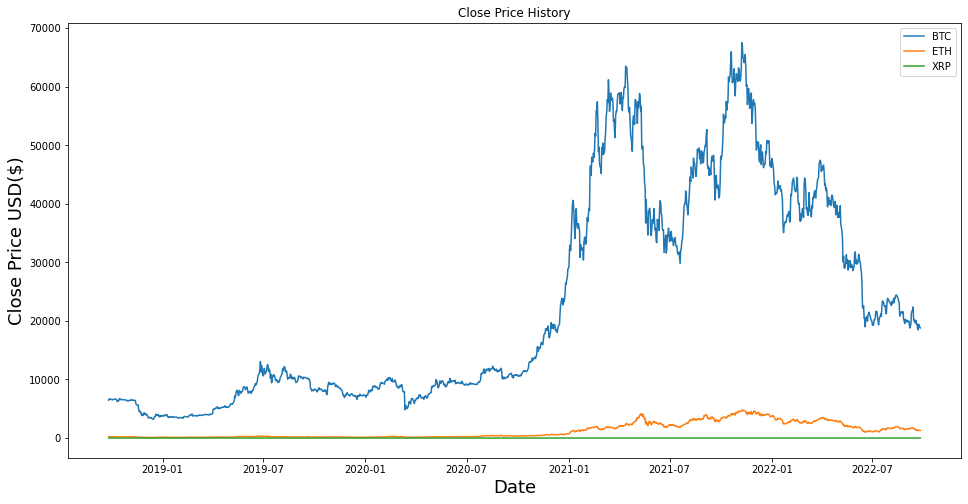

In [8]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(btc_df['Price'])
plt.plot(eth_df['Price'])
plt.plot(xrp_df['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.legend(['BTC', 'ETH', 'XRP'])
plt.show()

In [6]:
nbtc_df, neth_df, nxrp_df = btc_df.copy(), eth_df.copy(), xrp_df.copy()
nbtc_df['AssetName'], neth_df['AssetName'], nxrp_df['AssetName'] = 'BTC', 'ETH', 'XRP'
#nbtc_df['AssetID'], neth_df['AssetID'], nxrp_df['AssetID'] = 1, 2, 3

crypto_df = pd.concat([nbtc_df, neth_df, nxrp_df])

In [67]:
crypto_df.head()

,Price,AssetName
Date,,
2022-09-25,18803.2,BTC
2022-09-24,18925.2,BTC
2022-09-23,19293.5,BTC
2022-09-22,19404.0,BTC
2022-09-21,18489.0,BTC


In [7]:
crypto_df.index = crypto_df.index.astype('int64') // 10**9

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


In [8]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [9]:
# create dataframe with returns for all assets
all_assets = pd.DataFrame([])
for asset_name in ['BTC', 'ETH', 'XRP']:
  asset = crypto_df[crypto_df["AssetName"]==asset_name]
  #asset = asset.loc[totimestamp('09/26/2018'):totimestamp('09/25/2022')]
  print(asset.head())
  #asset = asset.reindex(range(asset.index[-1], asset.index[0]+86400*30, 86400*30), method='pad')
  lret = log_return(asset.Price)[1:]
  all_assets = all_assets.join(lret, rsuffix=asset_name, how="outer")

              Price AssetName
Date                         
1664064000  18803.2       BTC
1663977600  18925.2       BTC
1663891200  19293.5       BTC
1663804800  19404.0       BTC
1663718400  18489.0       BTC
              Price AssetName
Date                         
1664064000  1294.26       ETH
1663977600  1317.00       ETH
1663891200  1327.96       ETH
1663804800  1326.44       ETH
1663718400  1247.74       ETH
              Price AssetName
Date                         
1664064000  0.49202       XRP
1663977600  0.48781       XRP
1663891200  0.50768       XRP
1663804800  0.48522       XRP
1663718400  0.39403       XRP


In [10]:
all_assets.columns = ['PriceBTC', 'PriceETH', 'PriceXRP']

In [11]:
corr = all_assets.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,PriceBTC,PriceETH,PriceXRP
PriceBTC,1.00,0.84,0.62
PriceETH,0.84,1.00,0.67
PriceXRP,0.62,0.67,1.00


In [4]:
btc_df = btc_df.iloc[::-1]

# LSTM

In [5]:
btc_df.head()

,Price
Date,
2018-09-26,6468.1
2018-09-27,6689.2
2018-09-28,6636.0
2018-09-29,6603.9
2018-09-30,6635.2


**Note:** Comparing to other models, LSTM need to slice the train data first, in our case the train data was sliced into 7 days window.
LSTM will decide if some windows need to be forgotten, which means it may not fully leverage all train data.

In [148]:
def norm_train_test_split(data, time_step):
    # convert to numpy array
    dataset = data.values
    # get the number of rows to train the model on
    train_data_len = math.ceil(len(dataset) * .8)

    # scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)   
    
    train_data = scaled_data[0:train_data_len, :]
    # test_data = scaled_data[train_data_len-60:, :], we need -60 to get the values for predicting front rows in test set
    # split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
        
    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    # create a new array containing scaled values from index 980 to 1040
    test_data = scaled_data[train_data_len-time_step:, :]
    x_test = []
    y_test = dataset[train_data_len:, :] # not scaled but normal values in dataset
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
    x_test = np.array(x_test)
    
    return x_train, y_train, x_test, y_test

In [149]:
x_train, y_train, x_test, y_test = norm_train_test_split(btc_df, 7)

In [150]:
# reshape the date, LSTM expects the data to be 3-dimensional, number of sample, number of time steps, number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# convert to np and reshape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
# build the LSTM model
model = Sequential()
#model.add(LSTM(32, return_sequences=False, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(30, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(.2)) # Fraction of the input units to drop
model.add(LSTM(50, return_sequences=False))
#model.add(Dropout(.2))
model.add(Dense(25))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')   

In [162]:
model = Sequential()
for i in range(1):
    model.add(
        LSTM(
            units=20,
            dropout=0,
            activation='sigmoid',
            return_sequences=True, 
            input_shape = (x_train.shape[1], 1))
        )
model.add(
    LSTM(
        units=40,
        dropout=0.05,
        activation='sigmoid',
        return_sequences=False
    )
)

model.add(Dense(25))
model.add(Dense(1))

# We compile our model with a sampled learning rate.
adam = optimizers.Adam(
    learning_rate=0.002
)
model.compile(
    optimizer=adam, 
    loss='mean_squared_error'
) 

In [163]:
# train the mode
early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                               patience = 5)
model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop])

Epoch 1/100
10/10 [==============================] - 2s 7ms/step - loss: 0.1008
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0904
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0833
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0823
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0807
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0812
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0846
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0751
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0722
Epoch 10/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0663
Epoch 11/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0580
Epoch 12/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0497
Epoch 13/100
10/10 [=================

In [154]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 7, 20)             1760      
                                                                 
 lstm_11 (LSTM)              (None, 40)                9760      
                                                                 
 dense_10 (Dense)            (None, 25)                1025      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 12,571
Trainable params: 12,571
Non-trainable params: 0
_________________________________________________________________


In [164]:
# prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 [==============================] - 0s 1ms/step


In [165]:
# evaluate, get the RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1001.0498983304794

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


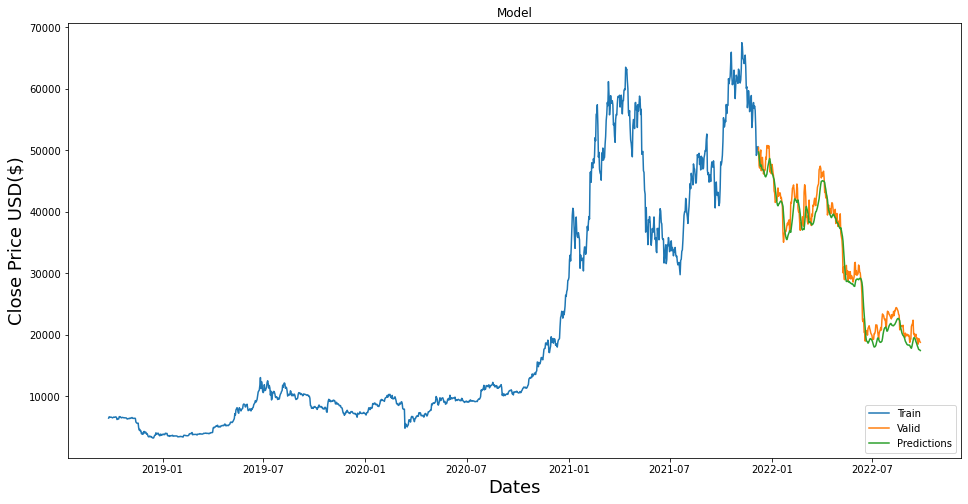

In [166]:
# plot
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predections'] = predictions
# visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predections']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [108]:
valid.tail(10)

,Price,Predections
Date,,
2022-09-16,19802.4,21995.279297
2022-09-17,20113.5,21700.080078
2022-09-18,19418.8,21474.802734
2022-09-19,19538.9,21122.419922
2022-09-20,18872.4,20832.789062
2022-09-21,18489.0,20604.962891
2022-09-22,19404.0,20324.210938
2022-09-23,19293.5,20297.117188
2022-09-24,18925.2,20241.548828


In [29]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    global x_train, y_train, x_test, y_test
    
    tf.keras.utils.set_random_seed(42)
    time_step = 7
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            LSTM(
                units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                return_sequences=True,
                #input_shape = (x_train.shape[1], 1)
            )
        )
    model.add(
        LSTM(
            units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
            dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
            activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
            return_sequences=False
        )
    )    
    
    model.add(Dense(25))
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = btc_df.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train = []
        y_train = []
        for i in range(time_step, len(train_data)):
            x_train.append(train_data[i-time_step:i, 0])
            y_train.append(train_data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        x_test = []
        y_test = []
        for i in range(time_step, len(test_data)):
            x_test.append(test_data[i-time_step:i, 0])
            y_test.append(test_data[i, 0])
        x_test = np.array(x_test)
        y_test = np.array(y_test)

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 5)
        model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        score = np.sqrt(np.mean(predictions - y_test)**2)
        all_rmse.append(score)
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=40)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-10-27 17:25:31,976] A new study created in memory with name: no-name-d266948b-e176-4414-bc15-140305d113ef


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:25:40,442] Trial 0 finished with value: 1263.792378757283 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 7.33041756442695e-05}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 17:25:52,417] Trial 1 finished with value: 2337.2168271649894 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.0001775371026133795}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:26:00,560] Trial 2 finished with value: 3170.466882696637 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.0033798278015381485}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:26:17,814] Trial 3 finished with value: 7489.790630151782 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 1.915781779226395e-05}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:26:26,574] Trial 4 finished with value: 14746.939549870895 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 8.247038629287765e-05}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:26:43,041] Trial 5 finished with value: 3890.6185289906643 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 4.1018980989908086e-05}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:27:02,638] Trial 6 finished with value: 8339.656962269928 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 1.5083479270761017e-05}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:27:12,965] Trial 7 finished with value: 7840.422010891154 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'activation1': 'sigmoid', 'unit_cnt2': 30, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.006156629845433241}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 17:27:32,572] Trial 8 finished with value: 7218.024260709084 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 50, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.00015227821374956896}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:27:38,835] Trial 9 finished with value: 1604.0100069518007 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.00011427307205701569}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:27:52,593] Trial 10 finished with value: 4404.091943276615 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.04031438042218528}. Best is trial 0 with value: 1263.792378757283.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:28:00,764] Trial 11 finished with value: 1231.2997799423993 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0007576666122256888}. Best is trial 11 with value: 1231.2997799423993.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:28:08,151] Trial 12 finished with value: 1130.3773926608844 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0006753286179946653}. Best is trial 12 with value: 1130.3773926608844.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:28:15,338] Trial 13 finished with value: 1360.6433983547402 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0007946061644082028}. Best is trial 12 with value: 1130.3773926608844.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:28:25,106] Trial 14 finished with value: 1567.4682895259534 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0006921475376107498}. Best is trial 12 with value: 1130.3773926608844.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:28:32,675] Trial 15 finished with value: 2309.020766187765 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.003346777650838479}. Best is trial 12 with value: 1130.3773926608844.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:28:40,170] Trial 16 finished with value: 901.4749785652808 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.000415168608185847}. Best is trial 16 with value: 901.4749785652808.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:28:51,472] Trial 17 finished with value: 6474.336523271982 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.016969290187669878}. Best is trial 16 with value: 901.4749785652808.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:29:03,567] Trial 18 finished with value: 7386.739175549525 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.00028861847439951005}. Best is trial 16 with value: 901.4749785652808.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:29:12,490] Trial 19 finished with value: 1434.7911713784429 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.0019390053870358254}. Best is trial 16 with value: 901.4749785652808.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:29:24,782] Trial 20 finished with value: 1818.513864704714 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0003694824774186708}. Best is trial 16 with value: 901.4749785652808.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:29:31,812] Trial 21 finished with value: 1425.6080469577594 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.001008990563616588}. Best is trial 16 with value: 901.4749785652808.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:29:39,698] Trial 22 finished with value: 901.4016465836863 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.000414980962779333}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:29:48,239] Trial 23 finished with value: 1088.3282023801644 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0003979074957308243}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:29:55,907] Trial 24 finished with value: 1076.818603681144 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0003362945644692624}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:30:02,948] Trial 25 finished with value: 1738.1139937268276 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.001635655429797575}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:30:12,291] Trial 26 finished with value: 2639.401496375132 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 3.565422891015848e-05}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:30:27,020] Trial 27 finished with value: 5905.52798811573 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 0.0002551880259633058}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:30:36,056] Trial 28 finished with value: 3650.8593976761126 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.010481197026409258}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:30:46,228] Trial 29 finished with value: 1431.4008798166049 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 4.838642416041777e-05}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:30:53,892] Trial 30 finished with value: 1784.5397095967958 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.001674608618448367}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:31:02,374] Trial 31 finished with value: 1082.6986986063296 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.000390186464860778}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:31:10,896] Trial 32 finished with value: 1762.027974460408 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0001730778199664913}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:31:19,311] Trial 33 finished with value: 1110.9274493511653 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0004466533637895988}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:31:27,428] Trial 34 finished with value: 1157.437732223252 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 9.518923836126786e-05}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:31:34,660] Trial 35 finished with value: 1506.2229001423464 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.00020307488560312133}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:31:41,432] Trial 36 finished with value: 7039.435393438825 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.00043323580843791207}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:31:57,793] Trial 37 finished with value: 2102.93168150821 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0011846593936113323}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:32:09,556] Trial 38 finished with value: 2928.5781043928764 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 6.100910514314143e-05}. Best is trial 22 with value: 901.4016465836863.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:32:28,769] Trial 39 finished with value: 13010.386790833554 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 2.6656729631524433e-05}. Best is trial 22 with value: 901.4016465836863.


Number of finished trials: 40
Best trial:
  Value: 901.4016465836863
  Params: 
    n_layers: 1
    unit_cnt1: 20
    dropout1: 0.05
    activation1: tanh
    unit_cnt2: 50
    dropout2: 0.1
    activation2: tanh
    adam_lr: 0.000414980962779333


8/8 [==============================] - 0s 2ms/step
cv_rmse= 632.3285243147511


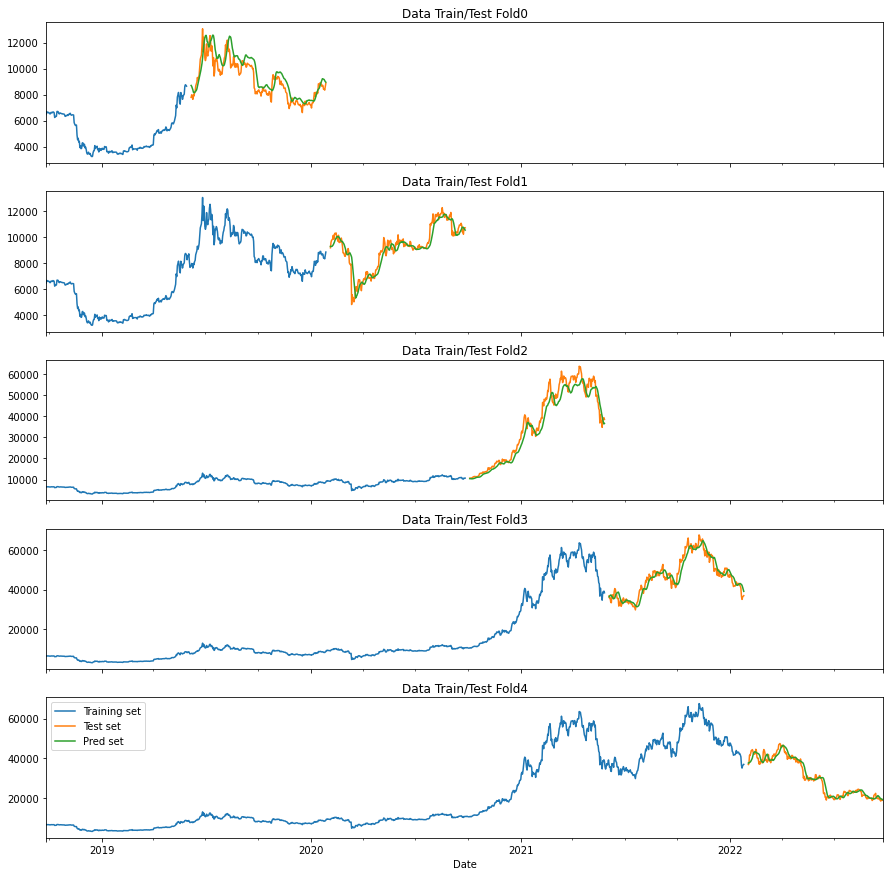

In [30]:
tf.keras.utils.set_random_seed(42)
tss = TimeSeriesSplit(n_splits=5)
time_step = 7
rmse = []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(btc_df):
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train = []
    y_train = []
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))    

    model = Sequential()
    for i in range(1):
        model.add(
            LSTM(
                units=20,
                dropout=0.05,
                activation='tanh',
                return_sequences=True, 
                input_shape = (x_train.shape[1], 1))
            )
    model.add(
        LSTM(
            units=50,
            dropout=0.01,
            activation='tanh',
            return_sequences=False
        )
    )

    model.add(Dense(25))
    model.add(Dense(1))

    adam = optimizers.Adam(
        learning_rate=0.000414980962779333
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    # train the mode
    early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                   patience = 5)
    model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop], verbose=0)    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(np.sqrt(np.mean(predictions - y_test)**2))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
print('cv_rmse=', cv_rmse)
plt.legend()
plt.show()

In [31]:
rmse

[431.1946119405455,
 83.6932286149365,
 2231.5021790585274,
 132.9162771451273,
 282.3363248146186]

# BiLSTM

In [35]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    global x_train, y_train, x_test, y_test
    
    tf.keras.utils.set_random_seed(42)
    time_step = 7
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            Bidirectional(
                LSTM(
                    units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                    dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                    activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                    return_sequences=True
                )
            )
        )  
        
    model.add(
        Bidirectional(
            LSTM(
                units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
                activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
                return_sequences=False
            )
        )
    )    
    
    model.add(Dense(32))
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = btc_df.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train = []
        y_train = []
        for i in range(time_step, len(train_data)):
            x_train.append(train_data[i-time_step:i, 0])
            y_train.append(train_data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        x_test = []
        y_test = []
        for i in range(time_step, len(test_data)):
            x_test.append(test_data[i-time_step:i, 0])
            y_test.append(test_data[i, 0])
        x_test = np.array(x_test)
        y_test = np.array(y_test)

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 5)
        model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        score = np.sqrt(np.mean(predictions - y_test)**2)
        all_rmse.append(score)
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=30)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-10-27 18:39:20,301] A new study created in memory with name: no-name-c2e20529-d089-4367-8b56-0af82c8f3e65


8/8 [==============================] - 0s 5ms/step


[I 2022-10-27 18:40:23,161] Trial 0 finished with value: 15548.16845384501 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.00014866742180715987}. Best is trial 0 with value: 15548.16845384501.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:41:03,104] Trial 1 finished with value: 3593.1970244637187 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.2, 'activation2': 'sigmoid', 'adam_lr': 4.7803068044098326e-05}. Best is trial 1 with value: 3593.1970244637187.


8/8 [==============================] - 0s 5ms/step


[I 2022-10-27 18:41:22,402] Trial 2 finished with value: 1441.386535023835 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.0006896124300798926}. Best is trial 2 with value: 1441.386535023835.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:41:47,184] Trial 3 finished with value: 3611.938133689751 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.0018950308472107254}. Best is trial 2 with value: 1441.386535023835.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:42:05,065] Trial 4 finished with value: 1889.700071338718 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.006658718264606412}. Best is trial 2 with value: 1441.386535023835.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:42:27,033] Trial 5 finished with value: 22934.677391253972 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 50, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.08413668763135466}. Best is trial 2 with value: 1441.386535023835.


8/8 [==============================] - 0s 5ms/step


[I 2022-10-27 18:43:14,546] Trial 6 finished with value: 7968.241513837395 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0.2, 'activation2': 'sigmoid', 'adam_lr': 0.027234348743627686}. Best is trial 2 with value: 1441.386535023835.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:43:37,270] Trial 7 finished with value: 1232.0172223417635 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.00040152581066366967}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 9ms/step


[I 2022-10-27 18:44:37,358] Trial 8 finished with value: 4221.805193077993 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.0033903792268458045}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 7ms/step


[I 2022-10-27 18:46:01,307] Trial 9 finished with value: 11087.10531283104 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.2, 'activation1': 'sigmoid', 'unit_cnt2': 30, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 0.04423888966012443}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:46:29,454] Trial 10 finished with value: 1339.7967414261122 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0003516296559586706}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 5ms/step


[I 2022-10-27 18:46:57,890] Trial 11 finished with value: 1337.337687119306 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.00035118162684306394}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:47:39,502] Trial 12 finished with value: 1450.1263876291048 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 1.6619574931952782e-05}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:48:06,562] Trial 13 finished with value: 1391.4009723417635 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.00011952040652408225}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:48:27,941] Trial 14 finished with value: 1533.7109723417639 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.0005207965196801128}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:48:53,300] Trial 15 finished with value: 2630.02893662275 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.009038896206496866}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 4ms/step


[I 2022-10-27 18:49:17,186] Trial 16 finished with value: 2512.8144110003973 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.00015387723984861158}. Best is trial 7 with value: 1232.0172223417635.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:49:35,517] Trial 17 finished with value: 959.1271009335276 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.0018209720106602536}. Best is trial 17 with value: 959.1271009335276.


8/8 [==============================] - 0s 5ms/step


[I 2022-10-27 18:50:18,376] Trial 18 finished with value: 2614.482769547802 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.1, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.0010793634362945242}. Best is trial 17 with value: 959.1271009335276.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:50:41,950] Trial 19 finished with value: 2874.503715820312 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.010231604188332051}. Best is trial 17 with value: 959.1271009335276.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:51:02,695] Trial 20 finished with value: 1511.32126423464 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.0021422886862010756}. Best is trial 17 with value: 959.1271009335276.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 18:51:18,386] Trial 21 finished with value: 885.471664045948 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.0002932431265709009}. Best is trial 21 with value: 885.471664045948.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:51:36,833] Trial 22 finished with value: 964.1368265029132 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 5.035886412013435e-05}. Best is trial 21 with value: 885.471664045948.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:52:01,791] Trial 23 finished with value: 1142.3608871822034 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 2.4798311710538907e-05}. Best is trial 21 with value: 885.471664045948.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:52:20,225] Trial 24 finished with value: 963.4242362950212 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 5.2684968242866755e-05}. Best is trial 21 with value: 885.471664045948.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:52:57,821] Trial 25 finished with value: 2301.977930184057 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 1.0188495153493763e-05}. Best is trial 21 with value: 885.471664045948.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:53:14,240] Trial 26 finished with value: 14856.20941588321 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 6.616112424564983e-05}. Best is trial 21 with value: 885.471664045948.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:53:24,749] Trial 27 finished with value: 861.8770768505032 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.0011001718638000548}. Best is trial 27 with value: 861.8770768505032.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 18:53:36,946] Trial 28 finished with value: 1124.217785354873 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.001187543544737269}. Best is trial 27 with value: 861.8770768505032.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 18:53:56,289] Trial 29 finished with value: 8056.998583901615 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.00017716145818636342}. Best is trial 27 with value: 861.8770768505032.


Number of finished trials: 30
Best trial:
  Value: 861.8770768505032
  Params: 
    n_layers: 1
    unit_cnt1: 20
    dropout1: 0.05
    activation1: tanh
    unit_cnt2: 30
    dropout2: 0.05
    activation2: tanh
    adam_lr: 0.0011001718638000548


8/8 [==============================] - 1s 2ms/step
cv_rmse= 601.1777085540253


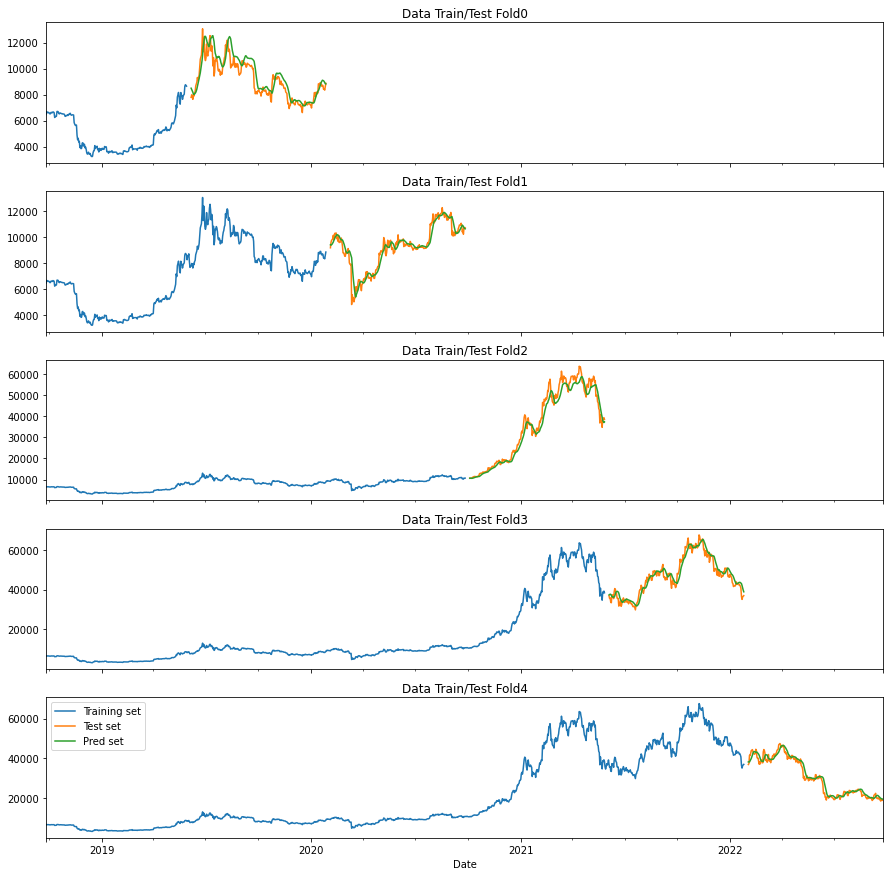

In [41]:
tf.keras.utils.set_random_seed(42)
tss = TimeSeriesSplit(n_splits=5)
time_step = 7
rmse = []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(btc_df):
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train = []
    y_train = []
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))    
    
    model = Sequential()
    for i in range(1):
        model.add(
            Bidirectional(
                LSTM(
                    units=20,
                    dropout=0.05,
                    activation='tanh',
                    return_sequences=True
                )
            )
    )
        
    model.add(
        Bidirectional(
            LSTM(
                units=30,
                dropout=0.05,
                activation='tanh',
                return_sequences=False
            )
        )
    )    
    
    model.add(Dense(32))
    model.add(Dense(1))

    adam = optimizers.Adam(
        learning_rate=0.0011001718638000548
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    # train the mode
    early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                   patience = 5)
    model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop], verbose=0)    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(np.sqrt(np.mean(predictions - y_test)**2))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
print('cv_rmse=', cv_rmse)
plt.legend()
plt.show()

In [42]:
rmse

[341.0661339711334,
 41.79357123940672,
 1499.609120928231,
 565.4197431144066,
 557.999973516949]

# GRU

In [23]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    # global x_train, y_train, x_test, y_test
    
    tf.keras.utils.set_random_seed(42)
    time_step = 7
    n_layers = trial.suggest_int("n_layers", 1, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            GRU(
                units=trial.suggest_categorical("unit_cnt1", [20, 30, 40, 50]),
                dropout=trial.suggest_categorical("dropout1", [0, 0.05, 0.1, 0.2]),
                activation=trial.suggest_categorical("activation1", ['sigmoid', 'tanh']),
                return_sequences=True,
                #input_shape = (x_train.shape[1], 1)
            )
        )
    model.add(
        GRU(
            units=trial.suggest_categorical("unit_cnt2", [20, 30, 40, 50]),
            dropout=trial.suggest_categorical("dropout2", [0, 0.05, 0.1, 0.2]),
            activation=trial.suggest_categorical("activation2", ['sigmoid', 'tanh']),
            return_sequences=False
        )
    )    
    
    model.add(Dense(1))

    # We compile our model with a sampled learning rate.
    adam = optimizers.Adam(
        learning_rate=trial.suggest_float("adam_lr", 1e-5, 1e-1, log=True) 
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    all_rmse = []
    fold = 0
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = btc_df.copy()
    dataset['Price'] = scaler.fit_transform(dataset) 
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train = []
        y_train = []
        for i in range(time_step, len(train_data)):
            x_train.append(train_data[i-time_step:i, 0])
            y_train.append(train_data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        x_test = []
        y_test = []
        for i in range(time_step, len(test_data)):
            x_test.append(test_data[i-time_step:i, 0])
            y_test.append(test_data[i, 0])
        x_test = np.array(x_test)
        y_test = np.array(y_test)

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
        
        early_stop = callbacks.EarlyStopping(monitor = 'loss', patience = 5)
        model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop], verbose=0)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        score = np.sqrt(np.mean(predictions - y_test)**2)     
        all_rmse.append(score)
        fold += 1
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=40)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-10-27 17:14:40,200] A new study created in memory with name: no-name-d7fe6931-ae10-4924-a276-a0e15fdfcf92


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:14:46,036] Trial 0 finished with value: 7433.68903576867 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 0.0019262565430022568}. Best is trial 0 with value: 7433.68903576867.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:14:53,319] Trial 1 finished with value: 2077.968342988612 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.00026483956062722466}. Best is trial 1 with value: 2077.968342988612.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:15:04,058] Trial 2 finished with value: 10704.715633400094 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'activation1': 'sigmoid', 'unit_cnt2': 50, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.0199339354134606}. Best is trial 1 with value: 2077.968342988612.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:15:10,742] Trial 3 finished with value: 14539.988088337526 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 4.5618481061157105e-05}. Best is trial 1 with value: 2077.968342988612.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:15:19,219] Trial 4 finished with value: 7699.959363579184 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.1, 'activation1': 'sigmoid', 'unit_cnt2': 20, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 0.0010912399065955414}. Best is trial 1 with value: 2077.968342988612.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:15:27,184] Trial 5 finished with value: 2707.3168278270655 and parameters: {'n_layers': 2, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0017014869369102314}. Best is trial 1 with value: 2077.968342988612.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:15:34,238] Trial 6 finished with value: 2361.5811734474314 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.05, 'activation2': 'sigmoid', 'adam_lr': 0.0032614004088310105}. Best is trial 1 with value: 2077.968342988612.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:15:42,328] Trial 7 finished with value: 1297.0886115432997 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0002547833449871206}. Best is trial 7 with value: 1297.0886115432997.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:15:51,702] Trial 8 finished with value: 1837.0065280720341 and parameters: {'n_layers': 2, 'unit_cnt1': 40, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.0009861315007811346}. Best is trial 7 with value: 1297.0886115432997.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:15:57,563] Trial 9 finished with value: 1522.0422628939357 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.0025760225948506426}. Best is trial 7 with value: 1297.0886115432997.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:16:07,450] Trial 10 finished with value: 2560.543656233448 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 1.5167863313789154e-05}. Best is trial 7 with value: 1297.0886115432997.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:16:13,643] Trial 11 finished with value: 5096.458335416116 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.0826246658047176}. Best is trial 7 with value: 1297.0886115432997.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:16:20,094] Trial 12 finished with value: 2121.6994534560386 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.00018815648326684094}. Best is trial 7 with value: 1297.0886115432997.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:16:25,255] Trial 13 finished with value: 3454.263077992585 and parameters: {'n_layers': 1, 'unit_cnt1': 20, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 30, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.009439451917652986}. Best is trial 7 with value: 1297.0886115432997.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:16:30,358] Trial 14 finished with value: 1107.5260838188558 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.000232012137523706}. Best is trial 14 with value: 1107.5260838188558.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:16:36,951] Trial 15 finished with value: 967.4922388936706 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0001882104290632474}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:16:42,627] Trial 16 finished with value: 1190.923431458554 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 7.939194618137534e-05}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:16:49,094] Trial 17 finished with value: 2747.8223087427173 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.2, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 2.8138110700895903e-05}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:16:58,794] Trial 18 finished with value: 8355.852040353548 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.00011378521149204702}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:17:04,433] Trial 19 finished with value: 1338.4164985268803 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.000509083797584917}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:17:09,762] Trial 20 finished with value: 1328.337606759799 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0.1, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.2, 'activation2': 'tanh', 'adam_lr': 0.00044387565570208073}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:17:16,303] Trial 21 finished with value: 1166.125611344677 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 4.9370716968209306e-05}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:17:28,274] Trial 22 finished with value: 2913.9338656978284 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 1.1366651104252155e-05}. Best is trial 15 with value: 967.4922388936706.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:17:35,241] Trial 23 finished with value: 960.8823872815149 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 4.9851385918663794e-05}. Best is trial 23 with value: 960.8823872815149.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:17:41,744] Trial 24 finished with value: 1165.8838765393273 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 0.00010801767693065249}. Best is trial 23 with value: 960.8823872815149.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:17:49,214] Trial 25 finished with value: 1544.7825333520918 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.05, 'activation2': 'tanh', 'adam_lr': 3.125809955440349e-05}. Best is trial 23 with value: 960.8823872815149.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:17:56,262] Trial 26 finished with value: 439.5928513142214 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.00042513412288630457}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:18:02,667] Trial 27 finished with value: 8039.828685675154 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.0005551710421941056}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:18:10,294] Trial 28 finished with value: 1123.276791412871 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 50, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.005016074883143475}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:18:22,460] Trial 29 finished with value: 13515.020860285356 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0, 'activation2': 'sigmoid', 'adam_lr': 8.304813897846714e-05}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:18:32,572] Trial 30 finished with value: 1896.9287272411282 and parameters: {'n_layers': 1, 'unit_cnt1': 40, 'dropout1': 0, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 2.104766925182162e-05}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:18:38,176] Trial 31 finished with value: 842.9314553264037 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0001794846989231385}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:18:45,298] Trial 32 finished with value: 929.5476455740202 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.00016266636843658693}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:18:52,353] Trial 33 finished with value: 973.899118776483 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 5.991466467074814e-05}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:18:58,845] Trial 34 finished with value: 1214.0370378707626 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.00014038497014126427}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:19:07,424] Trial 35 finished with value: 8829.548084923696 and parameters: {'n_layers': 1, 'unit_cnt1': 50, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.0003941435542678788}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:19:16,666] Trial 36 finished with value: 1125.1202788168696 and parameters: {'n_layers': 2, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 0.0007967794626631709}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 2ms/step


[I 2022-10-27 17:19:28,629] Trial 37 finished with value: 5144.6022468385845 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'sigmoid', 'unit_cnt2': 50, 'dropout2': 0, 'activation2': 'tanh', 'adam_lr': 0.0003282298118314011}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 3ms/step


[I 2022-10-27 17:19:40,651] Trial 38 finished with value: 1735.053858497749 and parameters: {'n_layers': 2, 'unit_cnt1': 50, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 40, 'dropout2': 0.1, 'activation2': 'sigmoid', 'adam_lr': 0.001465264643024504}. Best is trial 26 with value: 439.5928513142214.


8/8 [==============================] - 0s 1ms/step


[I 2022-10-27 17:19:48,675] Trial 39 finished with value: 1750.4093706137446 and parameters: {'n_layers': 1, 'unit_cnt1': 30, 'dropout1': 0.05, 'activation1': 'tanh', 'unit_cnt2': 20, 'dropout2': 0.1, 'activation2': 'tanh', 'adam_lr': 4.1269152267987784e-05}. Best is trial 26 with value: 439.5928513142214.


Number of finished trials: 40
Best trial:
  Value: 439.5928513142214
  Params: 
    n_layers: 1
    unit_cnt1: 30
    dropout1: 0
    activation1: tanh
    unit_cnt2: 40
    dropout2: 0.1
    activation2: tanh
    adam_lr: 0.00042513412288630457


8/8 [==============================] - 0s 1ms/step
cv_rmse= 357.304613099179


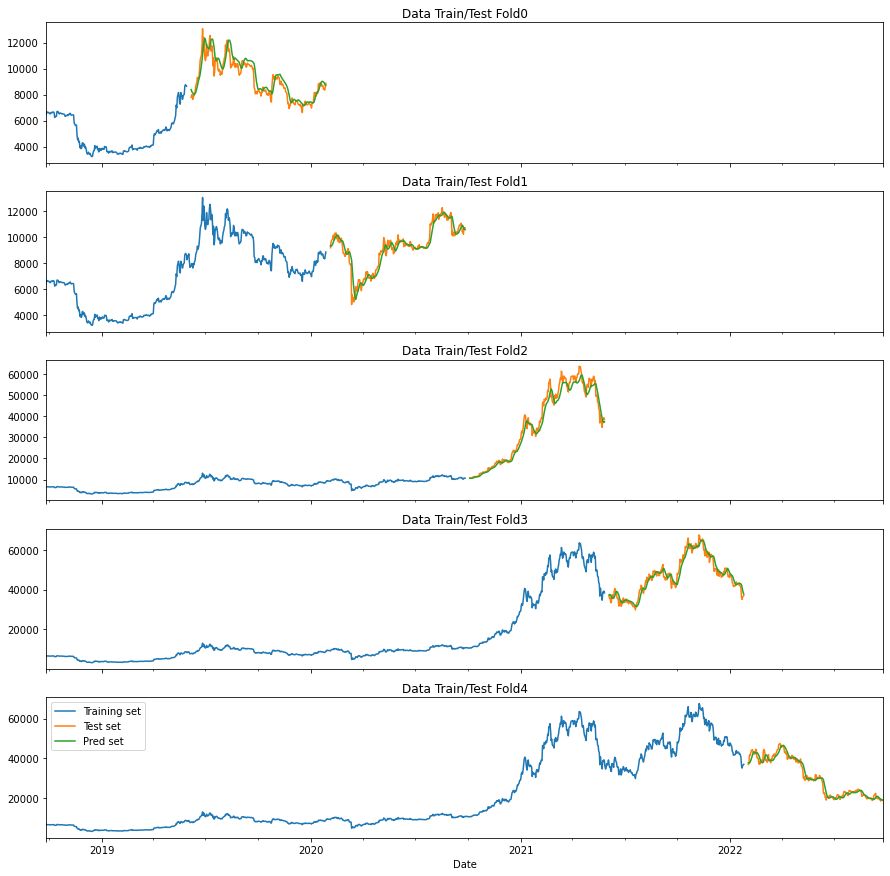

In [24]:
tf.keras.utils.set_random_seed(42)
tss = TimeSeriesSplit(n_splits=5)
time_step = 7
rmse = []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
scaler = MinMaxScaler(feature_range=(0,1))
dataset = btc_df.copy()
dataset['Price'] = scaler.fit_transform(dataset) 

for train_idx, test_idx in tss.split(btc_df):
    train_data = np.array(dataset.iloc[train_idx])
    test_data = np.array(dataset.iloc[test_idx])
    
    x_train = []
    y_train = []
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))    

    model = Sequential()
    for i in range(1):
        model.add(
            GRU(
                units=30,
                dropout=0,
                activation='tanh',
                return_sequences=True, 
                input_shape = (x_train.shape[1], 1))
            )   
    model.add(
        GRU(
            units=40,
            dropout=0.01,
            activation='tanh',
            return_sequences=False
        )
    )

    model.add(Dense(1))

    adam = optimizers.Adam(
        learning_rate=0.00042513412288630457
    )
    model.compile(
        optimizer=adam, 
        loss='mean_squared_error'
    ) 
    
    # train the mode
    early_stop = callbacks.EarlyStopping(monitor = 'loss',
                                                   patience = 5)
    model.fit(x_train, y_train, batch_size=128, epochs=100, callbacks = [early_stop], verbose=0)    
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse.append(np.sqrt(np.mean(predictions - y_test)**2))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
print('cv_rmse=', cv_rmse)
plt.legend()
plt.show()

In [25]:
rmse

[243.76546444650418,
 32.47296204647782,
 1262.8765583620234,
 193.17644663665234,
 54.231634004237215]

# XGBoost

In [111]:
def load_data():
    btc_df = pd.read_csv('BTCData.csv')
    eth_df = pd.read_csv('ETHData.csv')
    xrp_df = pd.read_csv('XRPData.csv')

    btc_df = btc_df.replace(',','', regex=True)
    btc_df = btc_df[['Price', 'Date']]
    btc_df['Date']= pd.to_datetime(btc_df['Date'])
    btc_df = btc_df.set_index("Date")
    btc_df['Price'] = pd.to_numeric(btc_df['Price'],errors='coerce')
    btc_df = btc_df[::-1]
    
    return btc_df

In [112]:
btc_df = load_data()

In [117]:
def train_test_split(data, time_step):
    # convert to numpy array
    dataset = data.values
    # get the number of rows to train the model on
    train_data_len = math.ceil(len(dataset) * .8)
    
    train_data = dataset[0:train_data_len, :]
    # test_data = data[train_data_len-60:, :], we need -60 to get the values for predicting front rows in test set
    # split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
        
    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    # create a new array containing scaled values from index 980 to 1040
    test_data = dataset[train_data_len-time_step:, :]
    x_test = []
    y_test = dataset[train_data_len:, :]
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
    x_test = np.array(x_test)
    
    return x_train, y_train, x_test, y_test

In [118]:
x_train, y_train, x_test, y_test = train_test_split(btc_df, 7)

In [20]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    # global x_train, y_train, x_test, y_test
    
    # tf.keras.utils.set_random_seed(42)
    time_step = 7
    xgb_params = {
        "n_estimators":trial.suggest_categorical("n_estimators", [400, 500, 600, 800, 1000]),
        "max_depth":trial.suggest_int("max_depth", 3, 10), 
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 6),
        'gamma': trial.suggest_categorical('gamma', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.05, 0.1, 1, 2, 3])
    }    
    
    model = XGBRegressor(**xgb_params, seed=42)
        
    all_rmse = []
    fold = 0
    dataset = btc_df.copy()
    
    # 5-fold time series CV
    tss = TimeSeriesSplit(n_splits=5)
    for train_idx, test_idx in tss.split(btc_df):
        train_data = np.array(dataset.iloc[train_idx])
        test_data = np.array(dataset.iloc[test_idx])

        x_train = []
        y_train = []
        for i in range(time_step, len(train_data)):
            x_train.append(train_data[i-time_step:i, 0])
            y_train.append(train_data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        x_test = []
        y_test = []
        for i in range(time_step, len(test_data)):
            x_test.append(test_data[i-time_step:i, 0])
            y_test.append(test_data[i, 0])
        x_test = np.array(x_test)
        y_test = np.array(y_test) 
        
        model.fit(x_train, y_train, verbose=False)

    #     Evaluate the model accuracy on the validation set.
    #     score = model.evaluate(x_test, y_test, verbose=0)
    #     return score
        predictions = model.predict(x_test)
        score = np.sqrt(np.mean(predictions - y_test)**2)
        all_rmse.append(score)
        fold += 1      
    return np.mean(all_rmse)


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=30)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-10-27 17:12:05,077] A new study created in memory with name: no-name-041dc50c-d596-4585-b26d-14480ad2fb10
[I 2022-10-27 17:12:08,064] Trial 0 finished with value: 5717.616785950742 and parameters: {'n_estimators': 800, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.3, 'reg_lambda': 1}. Best is trial 0 with value: 5717.616785950742.
[I 2022-10-27 17:12:10,400] Trial 1 finished with value: 5619.080336996822 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.2, 'reg_lambda': 3}. Best is trial 1 with value: 5619.080336996822.
[I 2022-10-27 17:12:11,756] Trial 2 finished with value: 5560.0723370464775 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.1, 'reg_lambda': 0.05}. Best is trial 2 with value: 5560.0723370464775.
[I 2022-10-27 17:12:12,382] Trial 3 finished with value: 5619.241311738611 and parameters: {'n_estimators': 400, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.1, 'reg_lambda': 1}. Be

Number of finished trials: 30
Best trial:
  Value: 5414.9464353813555
  Params: 
    n_estimators: 600
    max_depth: 10
    min_child_weight: 1
    gamma: 0.5
    reg_lambda: 0.1


cv_rmse= 5414.9464353813555


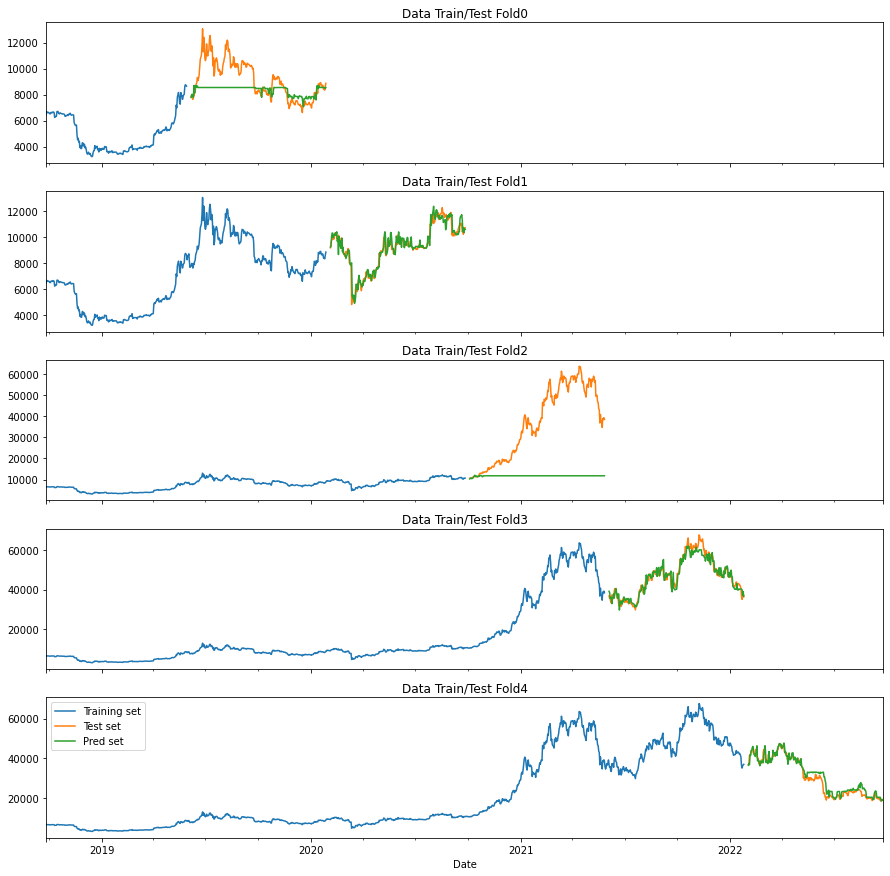

In [21]:
Best_trial = {'n_estimators': 600, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.5, 'reg_lambda': 0.1}
tss = TimeSeriesSplit(n_splits=5)
time_step = 7
rmse = []
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, test_idx in tss.split(btc_df):
    train_data = np.array(btc_df.iloc[train_idx])
    test_data = np.array(btc_df.iloc[test_idx])
    
    train_data_len = len(train_data)
    x_train = []
    y_train = []
    
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])

    #convert the x_train and y_train to np array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # create the testing dataset
    x_test = []
    y_test = []
    for i in range(time_step, len(test_data)):
        x_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    x_test = np.array(x_test)

    model = XGBRegressor(**Best_trial, seed=42)
    model.fit(x_train, y_train, verbose=False)

    predictions = model.predict(x_test)
    rmse.append(np.sqrt(np.mean(predictions - y_test)**2))
    
    train = btc_df.iloc[train_idx]
    valid = btc_df.iloc[test_idx[time_step:]]   
    valid['Predections'] = predictions
    train['Price'].plot(ax = axs[fold],
                   label = 'Training set',
                   title = f'Data Train/Test Fold{fold}')
    valid['Price'].plot(ax = axs[fold],
                   label = 'Test set')
    valid['Predections'].plot(ax = axs[fold],
                   label = 'Pred set')
    fold += 1
    
cv_rmse = np.mean(rmse)
print('cv_rmse=', cv_rmse)
plt.legend()
plt.show()

In [22]:
rmse

[776.1839239605403,
 52.23103399761657,
 24666.823968816207,
 412.1098765227756,
 1167.3833736096396]

# ARIMA

In [43]:
btc_df.head()

,Price
Date,
2018-09-26,6468.1
2018-09-27,6689.2
2018-09-28,6636.0
2018-09-29,6603.9
2018-09-30,6635.2


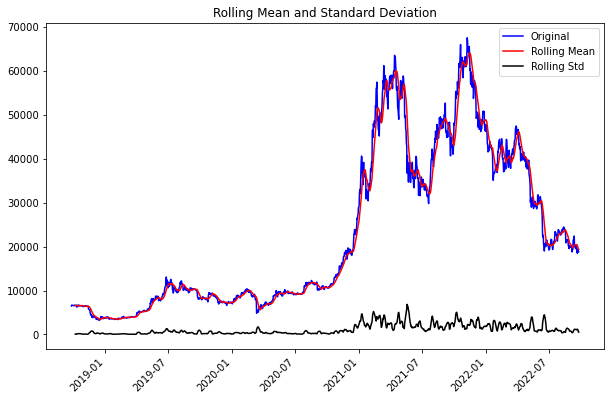

Results of dickey fuller test
Test Statistics                  -1.353307
p-value                           0.604446
No. of lags used                 12.000000
Number of observations used    1448.000000
critical value (1%)              -3.434874
critical value (5%)              -2.863538
critical value (10%)             -2.567834
dtype: float64


In [31]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() # rolling mean of 12 samples
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(btc_df)

We can’t rule out the Null hypothesis(The series has a unit root (value of a =1), i.e. , the series is said to be non-stationary) because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear. **Seasonality and trend may need to be separated from our series before we can undertake a time series analysis**. This approach will cause the resulting series to become stagnant.

<Figure size 720x432 with 0 Axes>

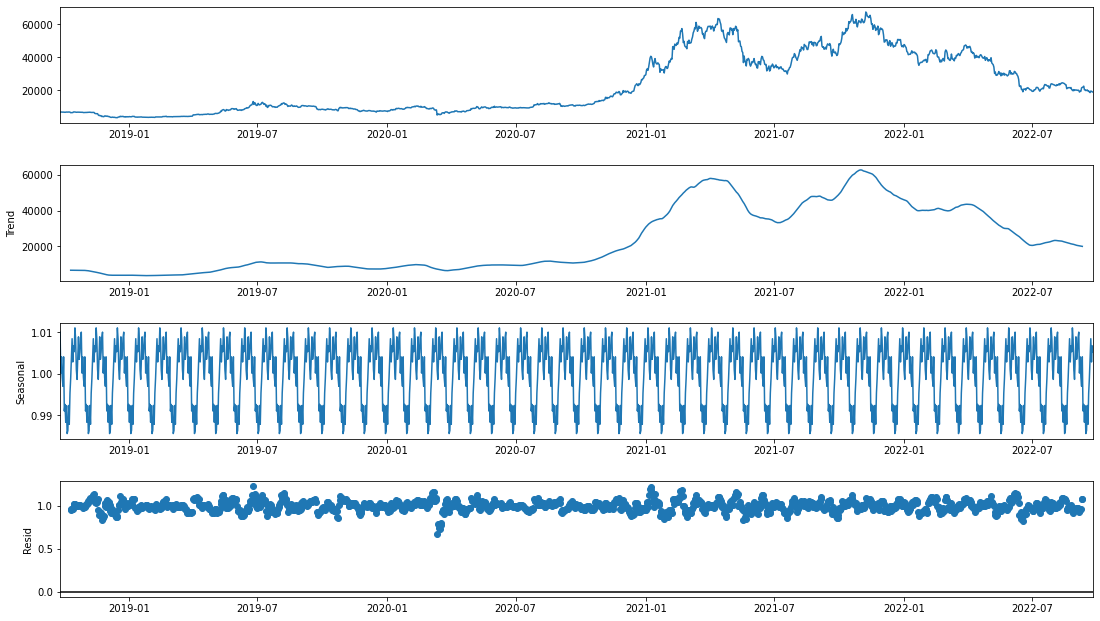

In [32]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(btc_df, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


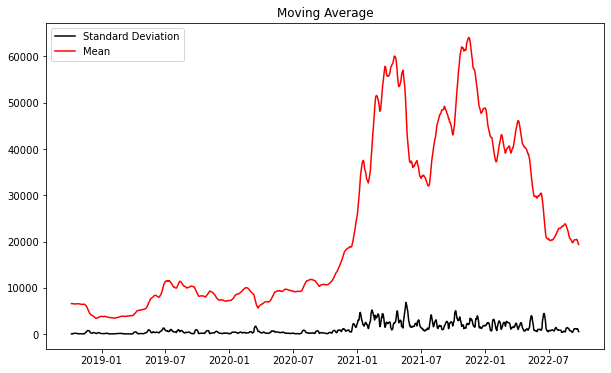

In [53]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# df_log = np.log(btc_df)
df_log = btc_df
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

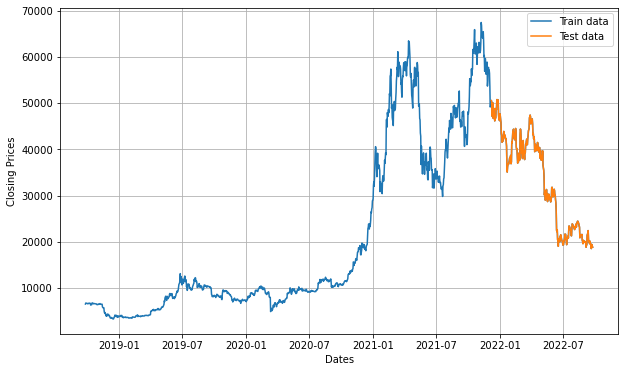

In [54]:
#split data into train and training set
train_data, test_data = df_log[:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19646.933, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19646.090, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19646.145, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19646.326, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19648.042, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19648.066, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19650.043, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19645.631, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19647.561, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19647.573, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19645.688, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19649.560, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.605 seconds
                               SARIMAX Results                              

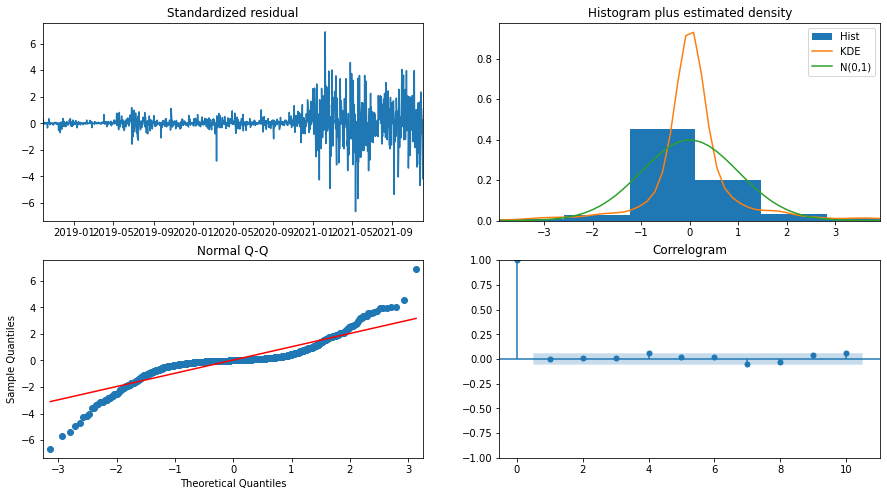

In [39]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [57]:
train_data, test_data = train_data.values, test_data.values
history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = np.sqrt(mean_squared_error(test_data, model_predictions))
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1184.6455243482496


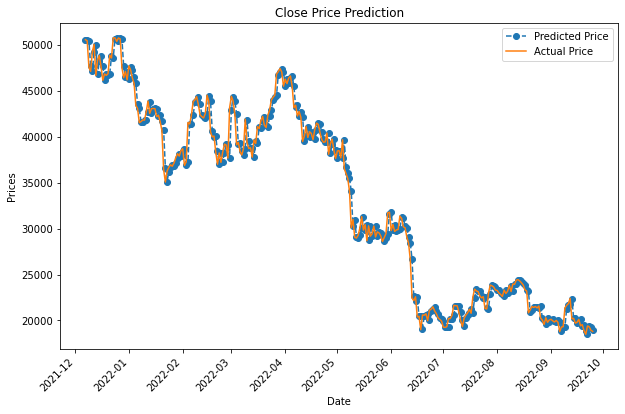

In [55]:
test_set_range = df_log[int(len(df_log)*0.8):].index
plt.figure(figsize=(10,6))
plt.plot(test_set_range, model_predictions, marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, label='Actual Price')
plt.title('Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

In [46]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1168
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9820.816
Date:                Wed, 12 Oct 2022   AIC                          19645.631
Time:                        15:54:17   BIC                          19655.756
Sample:                             0   HQIC                         19649.450
                               - 1168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0478      0.019     -2.490      0.013      -0.085      -0.010
sigma2      1.195e+06   2.07e+04     57.630      0.000    1.15e+06    1.24e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

# Facebook Prophet

In [12]:
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
import datetime as dt
pd.core.common.is_list_like = pd.api.types.is_list_like
import seaborn as sns
import matplotlib.dates as mdates

In [18]:
data = btc_df.reset_index()
data=data[["Date","Price"]]
data=data.rename(columns={"Date": "ds", "Price": "y"})

In [29]:
train_data_pro, test_data_pro = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [30]:
m = Prophet()
m.fit(train_data_pro)
future = m.make_future_dataframe(periods = test_data_pro.shape[0])
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1456,2022-09-21,71439.271245,41966.425294,103206.363811
1457,2022-09-22,71411.962225,42099.555316,104688.792613
1458,2022-09-23,71551.546230,42109.956743,104852.922606
1459,2022-09-24,71622.946107,42271.442465,104805.119789
1460,2022-09-25,71720.196979,42687.608484,104976.014617


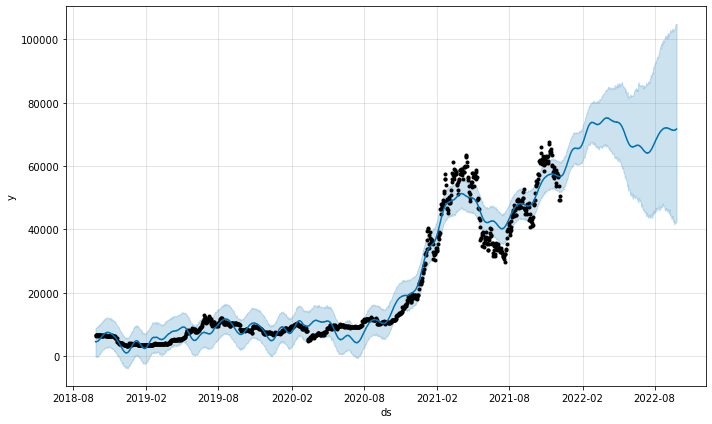

In [31]:
fig1 = m.plot(forecast)

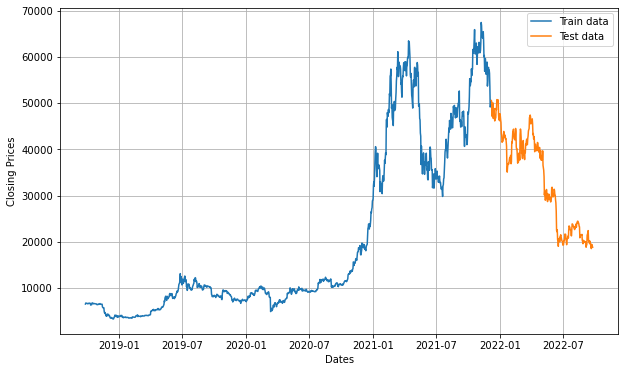

In [28]:
train_data, test_data = btc_df[:int(len(btc_df)*0.8)], btc_df[int(len(btc_df)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, label='Train data')
plt.plot(test_data, label='Test data')
plt.legend()

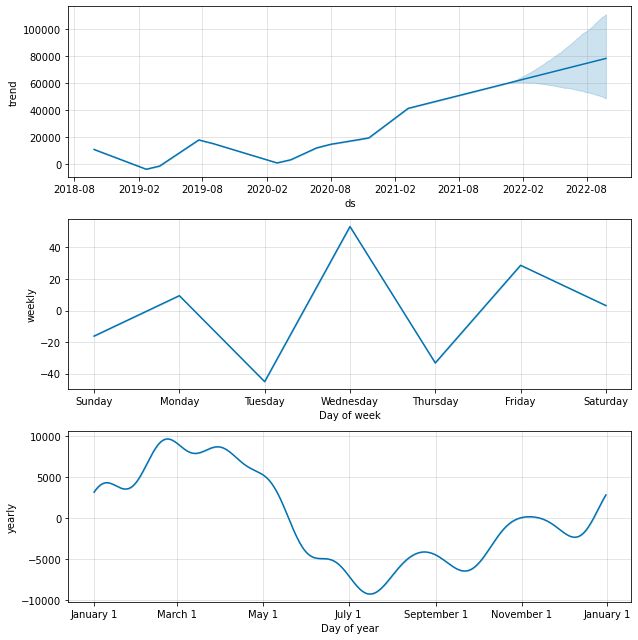

In [38]:
fig2 = m.plot_components(forecast)

In [36]:
rmse = np.sqrt(np.mean((forecast['yhat'] - test_data_pro['y']) ** 2))
print(rmse)

37481.99733585797
